# **Проект 5. Компьютер говорит нет!**
Целью - построение модели МО для вторичных клиентов банка, для принятия решения о выдаче кредина на основе данных из БКИ и анкет заёмщиков.


**Описания полей**

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

### **Библиотеки**

In [1]:
from pandas import Series
import numpy as np
import pandas as pd
import pandas_profiling

import operator
import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler, RobustScaler, OrdinalEncoder, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.model_selection import StratifiedKFold, cross_val_score , train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from catboost import CatBoost,CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
import lightgbm
from xgboost import XGBClassifier
import pickle

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, mean_squared_error, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,precision_recall_curve,average_precision_score

from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
import plotly.express as px
import datatable as dt
from sklearn import metrics
import itertools

from datetime import date
from datetime import datetime, timedelta

import warnings; warnings.simplefilter('ignore') # Убирает некритические сообщения
RANDOM_SEED = 40                                 # Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt                   # Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


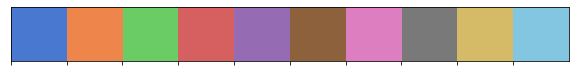

In [2]:
# показывать больше строк и столбцов данных pandas
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)
# pd.options.mode.chained_assignment = None 

sns.color_palette('muted')  # палитра
sns.palplot(sns.color_palette('muted'))

### 1. Загрузка набора данных

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [4]:
print('--- набор данных для обучения ---\nshape=', train.shape)
display(train.sample(5))
print('--- набор данных для тестирования ---\nshape=', test.shape)
display(test.sample(5))

--- набор данных для обучения ---
shape= (73799, 19)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
6283       14153  21JAN2014       GRD   F   42   N        N                0   
2951       26254  02FEB2014       SCH   F   50   N        N                0   
2351      103659  22APR2014       SCH   F   29   N        N                0   
14099      74557  22MAR2014       SCH   F   46   N        N                0   
22592      72383  20MAR2014       SCH   F   56   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
6283           1  -1.637937                2             80             2   
2951           1  -1.895097                4             50             1   
2351           0  -2.659634                2             70             1   
14099          0  -1.518134                1             60             1   
22592          0  -1.747170                6             50             1   

       work_address  income  sna  first_time foreign_passport  default  
6283              3   50000    1           4                N        0  
2951              2   29000    1           3                N        1  
2351              2   27000    1           4                N        0  
14099             2   18000    1           4                N        0  
22592             2   25000    1           3                N        0

--- набор данных для тестирования ---
shape= (36349, 18)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
8191        7634  15JAN2014       GRD   F   57   N        N                0   
27216      29307  05FEB2014       GRD   F   33   N        N                0   
4318       69312  18MAR2014       GRD   M   49   Y        Y                0   
28431      78711  26MAR2014       SCH   M   38   Y        Y                0   
3376       84450  01APR2014       UGR   M   27   Y        Y                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
8191           0  -1.922493                0             50             1   
27216          1  -1.434213                1             70             1   
4318           0  -2.630006                0             50             1   
28431          0  -1.472665               19             70             2   
3376           0  -1.430610                0             40             1   

       work_address  income  sna  first_time foreign_passport  
8191              1   28000    1           2                N  
27216             2   50000    1           3                N  
4318              2  150000    1           3                N  
28431             3   60000    1           3                N  
3376              3   40000    1           3                N

In [5]:
# Для корректной обработки данных объединим train и test в один датасет
train['sample'] = 1 # помечаем train
test['sample'] = 0 # помечаем test
test['default'] = 0 # т.к. значения дефолта отсутствуют для тестовой выборки, то пока
# заполним нулями

data = test.append(train, sort=False).reset_index(drop=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### 2. Первичный анализ набора данных

In [7]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Предварительные наблюдения:**

* 110148 строк, в т.ч. 73799 строк в наборе для обучения и 36349 строк в наборе для тестирования
* дублирующиеся строки не обнаружены
* Education содержит пропуски
* 7 числовых переменных, 10 категориальных и 3 поля Boolean (включая целевую переменную и признак набора для обечения/теста)
* ни у одного из полей нет большой корреляции с целевой переменной
* есть значимая корреляция между Доходом заёмщика и рейтингом региона

### 3. Предобработка данных
#### 3.1 Обработка NaN

In [8]:
# Education, ординарные признаки
#Образование - это ординарный признак, т.к. есть увеличение уровня образования
data["education"].unique()

array(['GRD', 'SCH', 'UGR', 'PGR', nan, 'ACD'], dtype=object)

In [9]:
data['education'].value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [10]:
print(f'Пустых значений: {data["education"].isna().sum()}, ' +
      f'это {100*data["education"].isna().sum() / len(data):0.2f}% от общего количества строк.')

Пустых значений: 478, это 0.43% от общего количества строк.


In [11]:
# Посмотрим, какое образование является модой
data["education"].mode()[0]

'SCH'

In [12]:
# заполним пропуски значением, которое встречается чаще всего
data["education"].fillna('SCH', inplace=True)

In [13]:
data['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

#### 3.2 Обработка признаков

In [14]:
# Cоздадим списки по категориям датасета.
# Rатегориальные, бинарные, числовые.

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'app_date', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [15]:
data.app_date

0         22MAR2014
1         24JAN2014
2         23MAR2014
3         03FEB2014
4         04FEB2014
            ...    
110143    04MAR2014
110144    24MAR2014
110145    22APR2014
110146    04JAN2014
110147    23JAN2014
Name: app_date, Length: 110148, dtype: object

In [16]:
# Преобразуем дату в день
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'] = data['app_date'].apply(lambda x: x.month)

# Переведем дату в катеогрию "численные", т.к. в дальнейшем это влияет на метрики модели
cat_cols.remove('app_date')
num_cols.append('app_date')

#### 3.3 Выбросы

In [17]:
data['income'].value_counts(bins=10)

(0.999, 100900.0]        105488
(100900.0, 200800.0]       3607
(200800.0, 300700.0]        656
(300700.0, 400600.0]        171
(400600.0, 500500.0]        106
(500500.0, 600400.0]         43
(900100.0, 1000000.0]        25
(600400.0, 700300.0]         22
(700300.0, 800200.0]         17
(800200.0, 900100.0]         13
Name: income, dtype: int64

In [18]:
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Column: ", col)
    print("Максимальное значение в данных:", data[col].max())
    print("Минимальное значение в данных:", data[col].min())
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  age
Максимальное значение в данных: 72
Минимальное значение в данных: 21
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].

Column:  decline_app_cnt
Максимальное значение в данных: 33
Минимальное значение в данных: 0
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].

Column:  income
Максимальное значение в данных: 1000000
Минимальное значение в данных: 1000
25%: 20000.0, 75%: 48000.0, IQR: 28000.0,  Borderline: [-22000.0, 90000.0].

Column:  bki_request_cnt
Максимальное значение в данных: 53
Минимальное значение в данных: 0
25%: 0.0, 75%: 3.0, IQR: 3.0,  Borderline: [-4.5, 7.5].

Column:  score_bki
Максимальное значение в данных: 0.19977285
Минимальное значение в данных: -3.62458632
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].

Column:  app_date
Максимальное значение в данных: 4
Минимальное значение в данных: 1
25%: 2.0, 75%: 3.0, IQR: 1.0,  Borderline: [0.5, 4.5].



Выбросы наблюдаются в колонках decline_app_cnt(количество отказанных прошлых заявок), income(доход заемщика), bki_request_cnt(количество обращений в БКИ) и score_bki.

Но:

1. Количество отказанных прошлых заявок в большинстве своем (более 85% равнялось 0) и удалять всех людей у которых были отказанные заявки абсолютно неправильно

2. Доход у 96,2% людей был не более 100 тыс., но ведь есть люди, у которых он сильно больше и этих людей надо учитывать...

3. Аналогичная ситуация и с количеством обращений

### 4. Визуализация

10.752880921895006


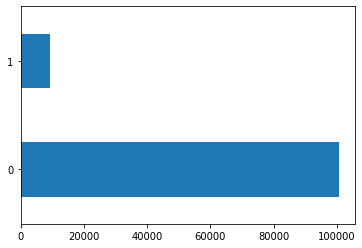

In [19]:
data['default'].value_counts().plot.barh()
print(len(data[data['default']==0])/len(data[data['default']==1]))

Клиенты без дефолта преобладают над клиентами с дефолтом почти в 11 раз.

Text(0.5, 1.0, 'income')

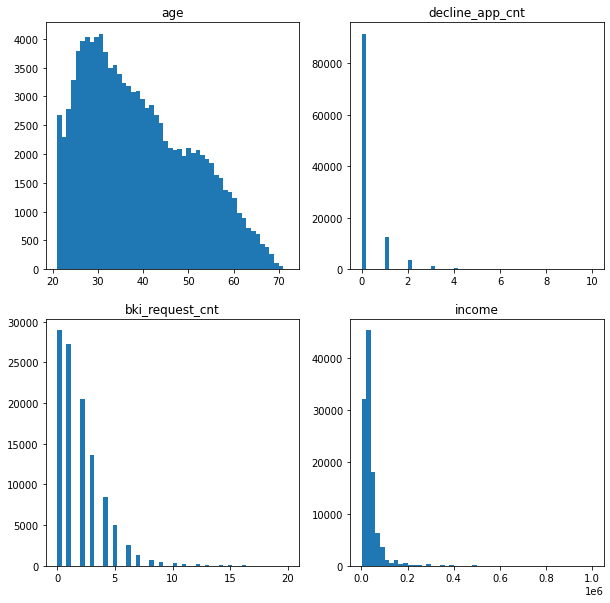

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

axes[0,0].hist(data['age'], bins = 50)
axes[0,0].set_title("age")

axes[0,1].hist(data['decline_app_cnt'], bins = 50, range=(0,10))
axes[0,1].set_title("decline_app_cnt")

axes[1,0].hist(data['bki_request_cnt'], bins = 50,  range=(0,20))
axes[1,0].set_title("bki_request_cnt")

axes[1,1].hist(data['income'], bins = 50)
axes[1,1].set_title("income")

Гистограммы  не являются нормальными и смещены вправо. При построении модели необходимо будет выполнить стандартизацию численных признаков.

### 5. Оценка корреляции

<AxesSubplot:>

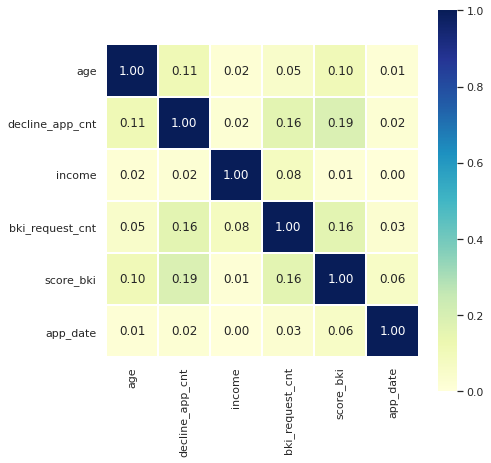

In [21]:
# Посмотрим матрицу коэффициента корреляции численных признаком
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu")

**Корреляция между числовыми признаками отсутствует**

### 6. Значимость непрерывных признаков

<AxesSubplot:>

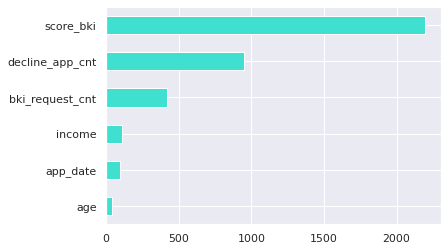

In [22]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='turquoise')

Скоринговый балл по данным из БКИ (score_bki) является одним из самых значимых числовых признаков

### 7. Оценка категориальных признаков

In [23]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
data['education'] = label_encoder.fit_transform(data['education'])
# убедимся в преобразовании    
data.head()


client_id  app_date  education  sex  age  car  car_type  decline_app_cnt  \
0      74835         3          1    1   29    1         1                0   
1      17527         1          3    0   39    0         0                5   
2      75683         3          4    1   50    1         1                0   
3      26883         2          3    1   56    0         0                0   
4      28862         2          1    0   38    0         0                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time  foreign_passport  sample  default  
0             2   50000    1           4                 0       0        0  
1             2    5000    4           3                 0       0        0  
2             2   30000    1           3                 1       0        0  
3             2   17000    1           3                 0       0        0  
4             3  120000    1           3                 0       0        0

<AxesSubplot:>

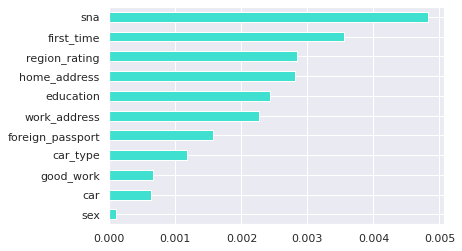

In [24]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='turquoise')

Исходя из анализа mutual_info_classif наиболее важным из категориальных признаков является "sna"

### 8.Feature Engineering

In [25]:
# Переведем колонки region_rating, first_time и home_address из категориальных в численные,
# т.к. при их стандартизации значение метрики roc-auc получается выше, чем при создании из
# них dummy-переменных
cat_cols.remove('region_rating')
num_cols.append('region_rating')

cat_cols.remove('first_time')
num_cols.append('first_time')

cat_cols.remove('home_address')
num_cols.append('home_address')

### 9. Подготовка данных к машинному обучению

In [26]:
# Преобразуем категориальные признаки с помощью get_dummies
data = pd.get_dummies(data, columns=cat_cols)

In [27]:
# выполним стандартизацию численных переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns=num_cols)

In [28]:
# Разделим обратно на train и test
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

In [29]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']

In [30]:
# Разделим выборку на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED, test_size=0.2)

### 10.Модели
#### Модель LogisticRegression

In [31]:
model_0 = LogisticRegression(max_iter = 1000)
model_0.fit(X_train, Y_train)
Y_pred = model_0.predict(X_test)

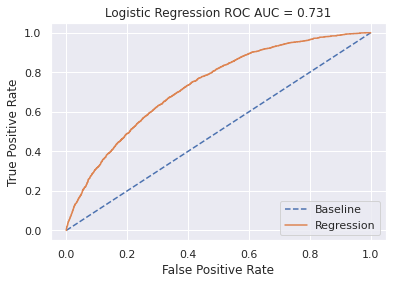

In [32]:
probs = model_0.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [33]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, Y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, Y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, Y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, Y_pred), 4)))

accuracy_score: 0.8736
f1_score: 0.0557
recall_score: 0.0296
MSE: 0.1264


In [34]:
confusion_matrix(Y_test, Y_pred)

array([[12840,    59],
       [ 1806,    55]])

<AxesSubplot:>

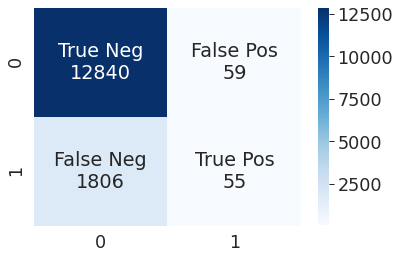

In [35]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, Y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=labels, fmt='', cmap='Blues')

Модель логистической регрессии с параметрами "по умолчанию" имеет достаточно высокую точность, однако, оценив матрицу ошибок, можно сделать вывод, что почти во всех случаях, когда клиент не способен выплатить кредит - модель все равно его выдаст. Данное решение приведет к падению доходов банка. Попробуем найти оптимальные гиперпараметры.

#### Модель LogisticRegression (гиперпараметры)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   30.8s finished


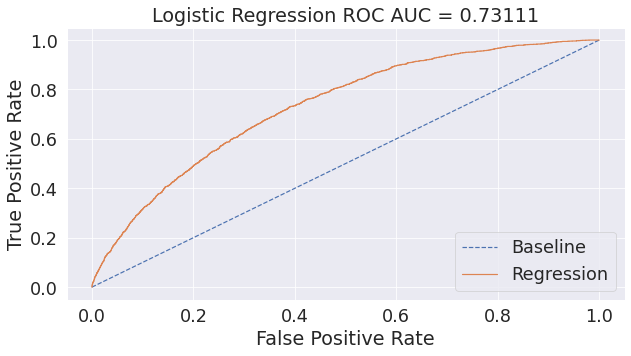

In [36]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [37]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.6726
f1_score: 0.3363
recall_score: 0.6577
MSE: 0.3274


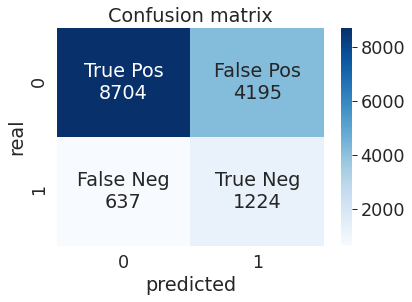

In [38]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Модель много ошибается и не выдает кредит клиентам, которые его выплатят (точность сильно понизилась относительно model), что ведет к уменьшению доходов банка. Оданако теперь модель не выдает кредит всем в подряд...

#### Модель LogisticRegression (undersampling)

В исходном датасете данные несбалансированные (один класс превосходит другой в 7 раз на train'е).
Попробуем выполнить undersampling, то есть случайным образом уменьшить преобладающий класс в 7 раз.

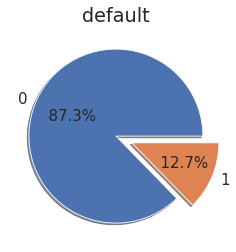

Класс 0 преобладает над классом 1 в 6.9 раз


In [39]:
plt.pie(x=train['default'].value_counts(),
       labels=list(train['default'].value_counts().index),
       autopct='%6.1f%%',
       explode=[0, 0.2],
       shadow=True,
       textprops={'fontsize': 15})
plt.title('default')
plt.show()

print('Класс 0 преобладает над классом 1 в {} раз'.format(
    round(train['default'].value_counts()[0]/train['default'].value_counts()[1],1)))

In [40]:
# Выберем случайным образом из train['default']==0 такое количество строк, которое
# равнялось бы train['default']==1, и затем объединим с train['default']==1.
under_train = pd.concat([train[train['default']==0].sample(
    len(train[train['default']==1]), random_state=RANDOM_SEED), train[train['default']==1]])

X = under_train.drop(columns = ['default', 'client_id'])
Y = under_train['default']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED, test_size=0.2)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.9s finished


Лучшие параметры модели:  {'C': 25.0, 'max_iter': 56}


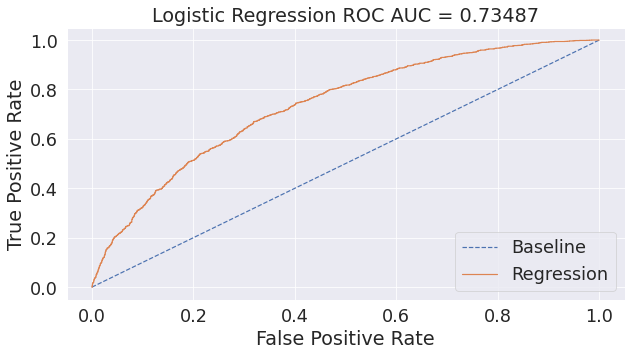

In [41]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=500,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

print("Лучшие параметры модели: ", model_best.best_params_)

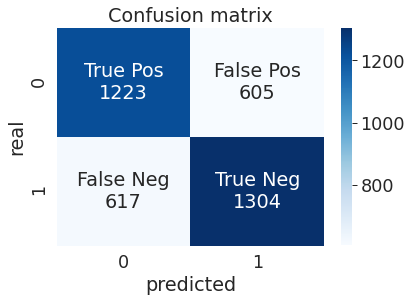

In [42]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Модель явно лучше стала предсказывать класс TrueNegative. В целом неплохо, но стоит попробовать более сложную модель.

#### Модель CatBoost

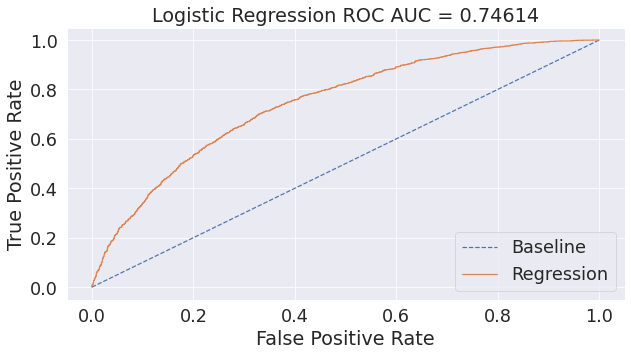

In [43]:
cat = CatBoostClassifier(n_estimators=1000,
                         depth=2,
                         logging_level='Silent')

cat.fit(X_train, Y_train)
probs = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [44]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))


accuracy_score: 0.6823
f1_score: 0.689
recall_score: 0.6866
MSE: 0.3177


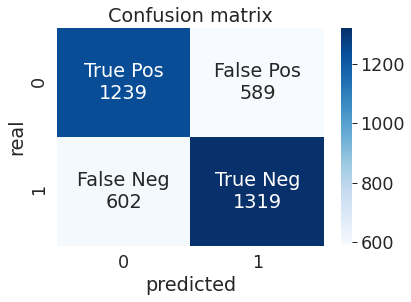

In [45]:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Результаты стали лучше, чем были в модели логистической регресии с гиперпараметрами, поэтому для submission будет использована модель CatBoostingClassifier

In [46]:
X_test2 = test.drop(columns = ['default', 'client_id'])
y_probs = cat.predict_proba(X_test2)[:,1]

In [47]:
test['default'] = y_probs

In [48]:
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

client_id   default
32074     106005  0.221835
233        74270  0.734625
16673      54455  0.249699
23472     105284  0.344639
26711      11583  0.507048
10692      80339  0.733738
31450       9800  0.455018
35496      32891  0.083733
35982      61901  0.683943
10298      79516  0.459521

(36349, 2)

In [49]:
submission.to_csv('submission.csv', index=False)